# Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series
- Nama: Kurniati Laeli Munifah
- Email: k.laelimunifah@gmail.com
- Id Dicoding: klmunifah

## Impor dan Pemrosesan Awal Dataset
Dataset yang digunakan adalah dataset LSTM-Multivariate_pollution.csv (https://www.kaggle.com/datasets/rupakroy/lstm-datasets-multivariate-univariate) . File berformat csv yang kemudian dibaca dengan menggunakan library pandas. Secara keseluruhan terdapat 43800 data pada masing-masing dari 9 kolom. Kolom yang digunakan adalah kolom date dan press yang kemudian disimpan dalam tabel df. Setelah ditemukan tidak ada data yang kosong pada masing-masing kolom, data dapat melalui proses selanjutnya

In [1]:
# Import Library
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Membaca dataset awal
df= pd.read_csv('/content/LSTM-Multivariate_pollution.csv')
df

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [3]:
# Menghapus kolom yang tidak diperlukan
df = df.drop(columns = ['dew', 'temp', 'pollution', 'wnd_dir', 'wnd_spd', 'snow', 'rain'])

In [4]:
# Mengecek data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    43800 non-null  object 
 1   press   43800 non-null  float64
dtypes: float64(1), object(1)
memory usage: 684.5+ KB


## Pemrosesan Lanjutan Data untuk Machine Learning
Selanjutnya dilakukan proses perubahan nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values menghasilkan dates dan press. Data array dates dan press dapat ditampilkan dalam sebuah grafik.  Untuk memudahkan model machine learning mencapai convergen, dilakukan normalisasi dengan fungsi MinMaxScaler dari library SKLearn. Agar dapat digunakan press harus diubah ukurannya dengan atribut reshape(-1,1). Nilai press hasil normalisasi disimpan pada press_scaled. Ukuran press_scaled berbeda dengan dates sehingga press_scaled diubah menjadi sebuah dataframe kembali lalu kolom press diekstrak menjadi sebuah array press_final. Sedangkan dates_final nilainya sama dengan dates. Selanjutnya dilakukan pembagian data training dan data validation dengan menggunakan train_test_split pada library SKLearn menjadi 80% data training dan 20% data validation. Langkah terakhir membuat fungsi  windowed_dataset yang menerima sebuah series/atribut kita yang telah di konversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch.Fungsi ini diterapkan pada press_train dan press_val membentuk train_set dan val_set.

In [5]:
# Mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values.
dates = df['date'].values
press = df['press'].values

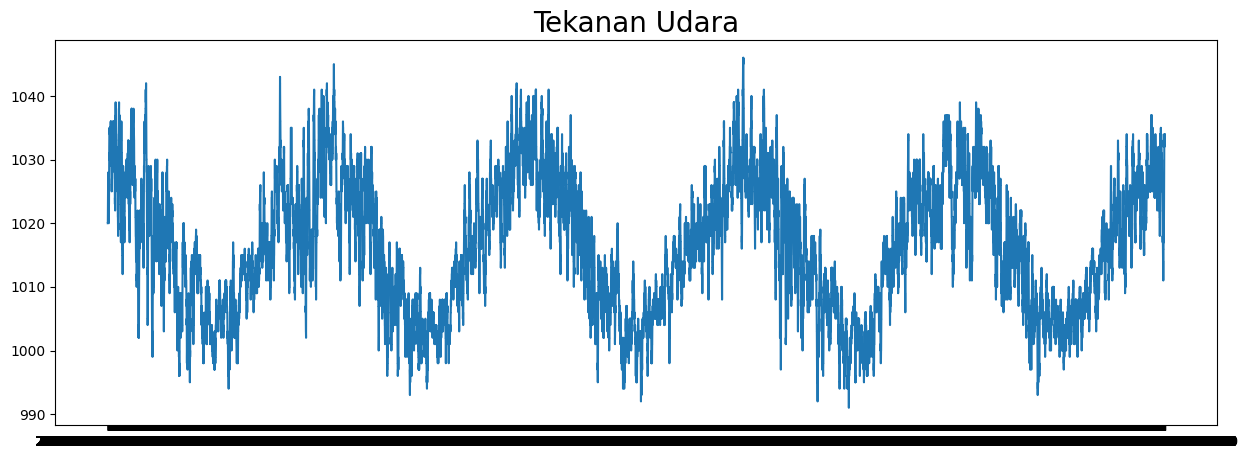

In [6]:
# Grafik Tekanan udara berdasarkan array dates, press
plt.figure(figsize=(15,5))
plt.plot(dates, press)
plt.title('Tekanan Udara',
          fontsize=20);

In [7]:
# Normalisasi dengan MinMaxScaler pada data press
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
press_scaled = min_max_scaler.fit_transform(press.reshape(-1,1))
press_scaled

array([[0.52727273],
       [0.52727273],
       [0.54545455],
       ...,
       [0.78181818],
       [0.78181818],
       [0.78181818]])

In [8]:
# Membuat press_final yang ukurannya sama dengan dates_final
dates_final = dates
press_final = pd.DataFrame(press_scaled, columns =['press'])
press_final = press_final['press'].values

In [9]:
#Membagi data menjadi data train dan data validation
from sklearn.model_selection import train_test_split
date_train, date_val, press_train, press_val = train_test_split(dates_final, press_final, test_size=0.2, shuffle=False)
print(date_train.shape, date_val.shape, press_train.shape, press_val.shape)

(35040,) (8760,) (35040,) (8760,)


In [10]:
# Membuat fungsi windowed_dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
# Menerapkan fungsi windowed_dataset ke press_train dan press_val
train_set = windowed_dataset(press_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(press_val, window_size=60, batch_size=100, shuffle_buffer=1000)

## Membuat dan Menguji Model Machine Learning dengan Data Time Series
Proses yang pertama kali dilakukan adalah membuat model sekuensial. Model sekuensial yang digunakan pada proyek ini terdiri dari layer LSTM, Dropout, Dense dengan activation relu dan softmax. Layer LSTM berguna untuk mengurutkan data dengan layer pertama LSTM memiliki parameter return_sequences yang bernilai True. Layer Dropout digunakan untuk menghapus beberapa nodes secara acak sehingga dapat mencegah terjadinya overfitting. Beberapa Layer Dense relu merupakan hidden layer yang berisi algoritma dari ML. Sedangkan layer Dense softmax merupakan layer untuk output.


Setelah model ML berhasil dibuat, model kemudian dicompile dengan menggunakan fungsi loss Huber. Optimizer yang digunakan adalah SGD yang menghitung penurunan gradien (dengan momentum dan parameter learning rate). Model compile ini akan mengitung parameter MAE (Mean Absolute error).

Terdapat satu kriteria yang mengharuskan model memiliki nilai MAE < 10% skala data. Sehingga dilakukan perhitungan nilai ambang batas (threshold_mae) yang tepat untuk data press_final. Diperoleh nilai threshold_mae 0,1.

Selanjutnya model ML dilatih dengan menggunakan fungsi fit sebanyak 100 kali epoch. Fungsi fit ini akan berhenti karena adanya Callback sudah mencapai MAE training dan MAE validation kurang dari threshold_mae(diatur 0,05).
Model fit ini disimpan dalam variable history sehingga dapat ditampilkan dalam sebuah grafik MAE dan Loss dari data training dan data validation menggunakan library matplotlib.

In [12]:
# Model sequential dengan 2 buah LSTM,
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(128,return_sequences=True),
  tf.keras.layers.LSTM(128),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [13]:
# Model compile
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [14]:
threshold_mae = (press_final.max() - press_final.min()) * 10/100
threshold_mae

0.1

In [15]:
# Membuat class callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.05 and logs.get('val_mae')<0.05):
      print("MAE dari model < 10% skala data")
      self.model.stop_training = True

callbacks = myCallback()

In [16]:
# Model Fit
history = model.fit(train_set, epochs=100,
                    validation_data= val_set, verbose=2, callbacks=[callbacks])

Epoch 1/100
350/350 - 137s - loss: 0.0619 - mae: 0.2955 - val_loss: 0.0253 - val_mae: 0.1803 - 137s/epoch - 391ms/step
Epoch 2/100
350/350 - 137s - loss: 0.0188 - mae: 0.1585 - val_loss: 0.0133 - val_mae: 0.1382 - 137s/epoch - 392ms/step
Epoch 3/100
350/350 - 137s - loss: 0.0150 - mae: 0.1447 - val_loss: 0.0120 - val_mae: 0.1318 - 137s/epoch - 390ms/step
Epoch 4/100
350/350 - 127s - loss: 0.0141 - mae: 0.1408 - val_loss: 0.0114 - val_mae: 0.1290 - 127s/epoch - 363ms/step
Epoch 5/100
350/350 - 126s - loss: 0.0135 - mae: 0.1376 - val_loss: 0.0110 - val_mae: 0.1268 - 126s/epoch - 361ms/step
Epoch 6/100
350/350 - 127s - loss: 0.0130 - mae: 0.1350 - val_loss: 0.0107 - val_mae: 0.1246 - 127s/epoch - 364ms/step
Epoch 7/100
350/350 - 137s - loss: 0.0125 - mae: 0.1320 - val_loss: 0.0103 - val_mae: 0.1224 - 137s/epoch - 391ms/step
Epoch 8/100
350/350 - 136s - loss: 0.0120 - mae: 0.1295 - val_loss: 0.0099 - val_mae: 0.1200 - 136s/epoch - 387ms/step
Epoch 9/100
350/350 - 129s - loss: 0.0115 - mae:

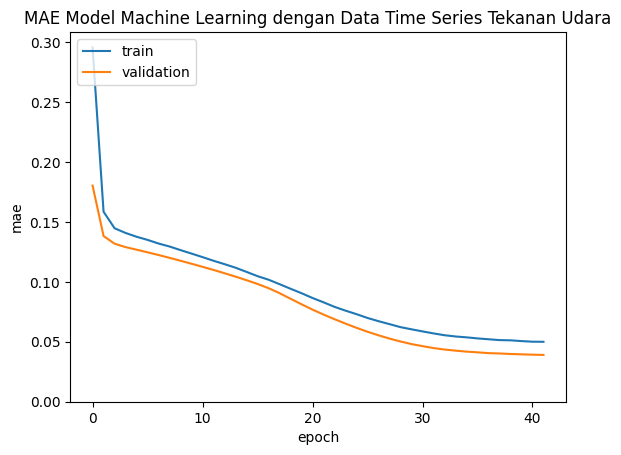

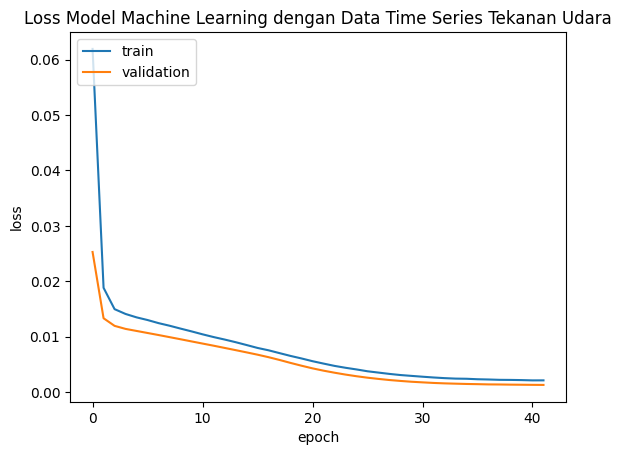

In [17]:
# Grafik
import matplotlib.pyplot as plt
# Grafik MAE
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE Model Machine Learning dengan Data Time Series Tekanan Udara')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.ylim(ymin=0)
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Grafik Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model Machine Learning dengan Data Time Series Tekanan Udara')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()